# Covid19 (Korea)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import plotly.offline as py

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
df_patient = pd.read_csv('/content/drive/My Drive/covid/PatientInfo.csv')
df_route = pd.read_csv('/content/drive/My Drive/covid/PatientRoute.csv')

## PatientInfo

In [5]:
df_patient.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [8]:
df_patient.shape

(2243, 18)

In [6]:
df_patient.isna().sum()

patient_id               0
global_num             906
sex                     96
birth_year             454
age                    258
country                  0
province                 0
city                    67
disease               2224
infection_case        1050
infection_order       2201
infected_by           1768
contact_number        1830
symptom_onset_date    2049
confirmed_date         145
released_date         2010
deceased_date         2213
state                   96
dtype: int64

### Preprocessing

In [0]:
df_patient['birth_year'] = df_patient['birth_year'].fillna(0.0).astype(int)
df_patient['birth_year'] = df_patient['birth_year'].map(lambda x : x if x > 0 else np.nan)
df_patient.confirmed_date = pd.to_datetime(df_patient.confirmed_date)
daily_count = df_patient.groupby('confirmed_date')['patient_id'].count()
accumulated_count = daily_count.cumsum()
df_patient['age'] = 2020 - df_patient['birth_year']

In [18]:
df_patient.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,group_age
0,1000000001,2.0,male,1964.0,56.0,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,50s
1,1000000002,5.0,male,1987.0,33.0,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released,30s
2,1000000003,6.0,male,1964.0,56.0,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,50s
3,1000000004,7.0,male,1991.0,29.0,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,20s
4,1000000005,9.0,female,1992.0,28.0,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released,20s


In [0]:
def group_age(age):
    import math
    if age >= 0:
        if age % 10 != 0:
            lower = int(age // 10) * 10
            upper = int(age // 10) * 10 + 9
            return f'{lower}-{upper}'
        else:
            lower = 0
            upper = 9
            return f'{lower}-{upper}'

    return 'Unknown'
df_patient['group_age'] = df_patient['age'].apply(group_age)

In [0]:
patient = df_patient

In [0]:
cols = ['confirmed_date', 'released_date', 'deceased_date']
for col in cols:
    patient[col] = pd.to_datetime(patient[col])

In [0]:
patient['time_to_release_since_confirmed'] = patient['released_date'] - patient['confirmed_date'] 
patient['time_to_death_since_confirmed'] = patient['deceased_date'] - patient['confirmed_date']
patient["duration_since_confirmed"] = patient[["time_to_release_since_confirmed", "time_to_death_since_confirmed"]].min(axis = 1)
patient['duration_days'] = patient['duration_since_confirmed'].dt.days
age_ranges = sorted(set([ga for ga in patient['group_age'] if ga != 'Unknown']))
released = patient[patient['state'] == 'released']
isolated = patient[patient['state'] == 'isolated']
dead = patient[patient['state'] == 'deceased']

### Confirmed Cases

Text(0.5, 1.0, 'Accumulated Confirmed Count')

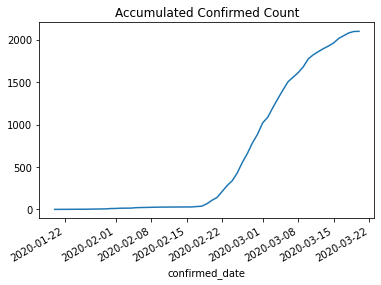

In [36]:
accumulated_count.plot(kind = 'line')
plt.title('Accumulated Confirmed Count')

## PatientRoute

In [38]:
df_route.head()

,patient_id,global_num,date,province,city,latitude,longitude
0,1400000001,1,2020-01-19,Incheon,Jung-gu,37.460459,126.440680
1,1400000001,1,2020-01-20,Incheon,Seo-gu,37.478832,126.668558
2,1000000001,2,2020-01-22,Gyeonggi-do,Gimpo-si,37.562143,126.801884
3,1000000001,2,2020-01-23,Seoul,Jung-gu,37.567454,127.005627
4,2000000001,3,2020-01-20,Incheon,Jung-gu,37.460459,126.440680


In [40]:
df_route.isna().sum()

patient_id    0
global_num    0
date          0
province      0
city          0
latitude      0
longitude     0
dtype: int64

### Cluster

In [83]:
clus = df_route.loc[:, ['latitude', 'longitude']]
clus.head()

,latitude,longitude
0,37.460459,126.440680
1,37.478832,126.668558
2,37.562143,126.801884
3,37.567454,127.005627
4,37.460459,126.440680


#### scipy

In [0]:
from scipy.cluster.vq import kmeans, vq
from scipy.spatial.distance import cdist

K = range(1, 10)

k_means = [kmeans(clus, k) for k in K]
centeroids = [cent for (cent, var) in k_means]

D_K = [cdist(clus, cent, 'euclidean') for cent in centeroids]

cIdx = [np.argmin(D,axis = 1) for D in D_K]
dist = [np.min(D, axis =1) for D in D_K]
avgWithinSS = [sum(d)/clus.shape[0] for d in dist]  

Text(0.5, 1.0, 'Elbow for K-Means clustering')

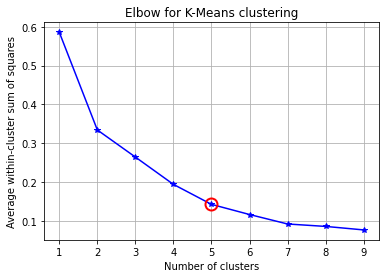

In [73]:
kIdx = 4

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker = 'o', markersize=12, 
      markeredgewidth = 2, markeredgecolor = 'r', markerfacecolor = 'None')

plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for K-Means clustering')  

#### sklearn

In [0]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters = 5, init ='k-means++')
k_means.fit(clus)
clus['cluster_label'] = k_means.fit_predict(clus)
centers = k_means.cluster_centers_
labels = k_means.predict(clus[clus.columns[:2]])

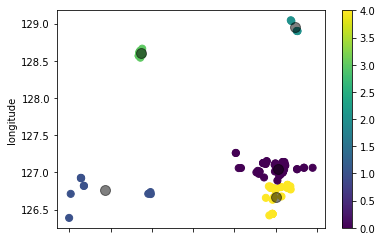

In [85]:
clus.plot.scatter(x = 'latitude', y = 'longitude', c = labels, s = 50, cmap = 'viridis')
plt.scatter(centers[:, 0], centers[:, 1], c = 'black', s = 100, alpha = 0.5)

In [0]:
data = daily_count.resample('D').first().fillna(0).cumsum()
x = np.arange(len(data)).reshape(-1, 1)
y = data.values

In [94]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(hidden_layer_sizes = [32, 32, 10],
                     max_iter = 50000,
                     alpha = 0.0005,
                     random_state = 2020)
model.fit(x, y)

MLPRegressor(activation='relu', alpha=0.0005, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=[32, 32, 10], learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=50000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=2020, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [0]:
from datetime import date, timedelta

test = np.arange(len(data)+7).reshape(-1, 1)
pred = model.predict(test)
prediction = pred.round().astype(int)
week = [data.index[0] + timedelta(days = i) for i in range(len(prediction))]
dt_idx = pd.DatetimeIndex(week)
predicted_count = pd.Series(prediction, dt_idx)

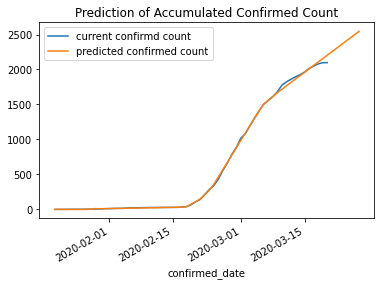

In [97]:
accumulated_count.plot()
predicted_count.plot()
plt.title('Prediction of Accumulated Confirmed Count')
plt.legend(['current confirmd count', 'predicted confirmed count'])
plt.show()

### Prophet

In [98]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot

prophet = pd.DataFrame(data)
prophet

,patient_id
confirmed_date,
2020-01-20,1.0
2020-01-21,1.0
2020-01-22,1.0
2020-01-23,2.0
2020-01-24,2.0
...,...
2020-03-16,2015.0
2020-03-17,2048.0
2020-03-18,2080.0


In [99]:
pr_data = prophet.reset_index()
pr_data.columns = ['ds', 'y']
pr_data

,ds,y
0,2020-01-20,1.0
1,2020-01-21,1.0
2,2020-01-22,1.0
3,2020-01-23,2.0
4,2020-01-24,2.0
...,...,...
56,2020-03-16,2015.0
57,2020-03-17,2048.0
58,2020-03-18,2080.0
59,2020-03-19,2097.0


In [100]:
model = Prophet()
model.fit(pr_data)
future = model.make_future_dataframe(periods = 365)
forecast = model.predict(future)
forecast

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-20,-3.910317,-29.724518,15.602261,-3.910317,-3.910317,-2.639129,-2.639129,-2.639129,-2.639129,-2.639129,-2.639129,0.0,0.0,0.0,-6.549446
1,2020-01-21,-2.535686,-25.623997,22.575248,-2.535686,-2.535686,1.630292,1.630292,1.630292,1.630292,1.630292,1.630292,0.0,0.0,0.0,-0.905394
2,2020-01-22,-1.161056,-18.828602,25.960034,-1.161056,-1.161056,5.240144,5.240144,5.240144,5.240144,5.240144,5.240144,0.0,0.0,0.0,4.079088
3,2020-01-23,0.213574,-21.395054,23.612574,0.213574,0.213574,1.252807,1.252807,1.252807,1.252807,1.252807,1.252807,0.0,0.0,0.0,1.466381
4,2020-01-24,1.588204,-25.414785,20.809414,1.588204,1.588204,-4.175948,-4.175948,-4.175948,-4.175948,-4.175948,-4.175948,0.0,0.0,0.0,-2.587743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,2021-03-16,17673.582381,-14379.683820,49279.158612,-14375.676494,49297.315616,1.630292,1.630292,1.630292,1.630292,1.630292,1.630292,0.0,0.0,0.0,17675.212674
422,2021-03-17,17716.537424,-14434.632595,49496.909376,-14415.657431,49476.991852,5.240144,5.240144,5.240144,5.240144,5.240144,5.240144,0.0,0.0,0.0,17721.777568
423,2021-03-18,17759.492467,-14462.597782,49617.229174,-14457.126676,49648.080730,1.252807,1.252807,1.252807,1.252807,1.252807,1.252807,0.0,0.0,0.0,17760.745274
424,2021-03-19,17802.447510,-14565.935583,49832.876042,-14557.588871,49819.169608,-4.175948,-4.175948,-4.175948,-4.175948,-4.175948,-4.175948,0.0,0.0,0.0,17798.271563


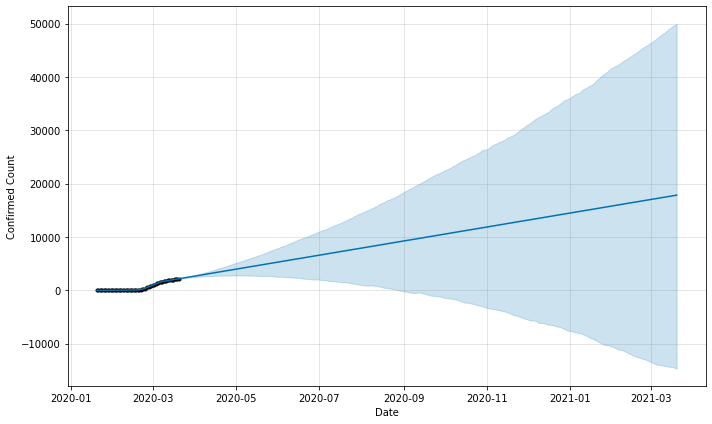

In [101]:
fig = plot_plotly(model, forecast)
py.iplot(fig)

fig = model.plot(forecast, xlabel = 'Date', ylabel = 'Confirmed Count')

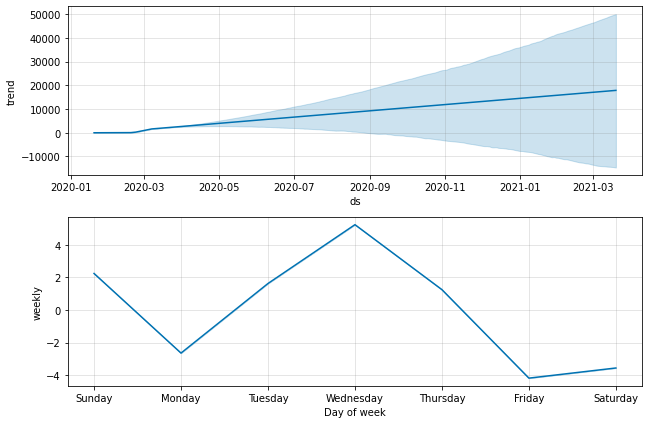

In [102]:
figure = model.plot_components(forecast)

### ARIMA

In [103]:
confirm_cs = prophet.cumsum()
arima_data = confirm_cs.reset_index()
arima_data.columns = ['confirmed_date', 'count']
arima_data

,confirmed_date,count
0,2020-01-20,1.0
1,2020-01-21,2.0
2,2020-01-22,3.0
3,2020-01-23,5.0
4,2020-01-24,7.0
...,...,...
56,2020-03-16,30578.0
57,2020-03-17,32626.0
58,2020-03-18,34706.0
59,2020-03-19,36803.0


In [106]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

model_arima = ARIMA(arima_data['count'].values, order = (1, 2, 1))
fit_model = model_arima.fit(trend = 'c', full_output = True, disp = True)
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D2.y   No. Observations:                   59
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -252.249
Method:                       css-mle   S.D. of innovations             17.146
Date:                Wed, 01 Apr 2020   AIC                            512.498
Time:                        12:45:39   BIC                            520.809
Sample:                             2   HQIC                           515.742
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.3500     24.879      0.939      0.352     -25.411      72.111
ar.L1.D2.y     0.9495      0.037     25.924      0.000       0.878       1.021
ma.L1.D2.y    -0.3023      0.116     -2.609      0.012      -0.529      -0.075
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0531           +0.0000j            1.0531            0.0000
MA.1            3.3085           +0.0000j            3.3085            0.0000
-----------------------------------------------------------------------------
"""

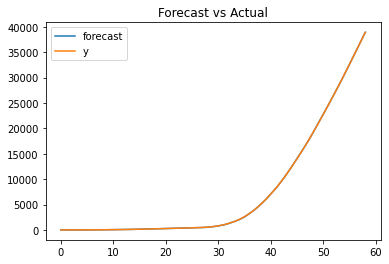

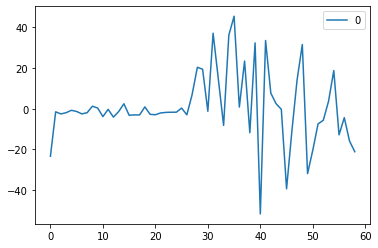

In [107]:
fit_model.plot_predict()
plt.title('Forecast vs Actual')
pd.DataFrame(fit_model.resid).plot()

In [108]:
forcast = fit_model.forecast(steps = 6)
pred_y = forcast[0].tolist()
pd.DataFrame(pred_y)

,0
0,41007.512302
1,43123.285505
2,45249.030440
3,47385.422073
4,49533.101318
5,51692.676751


### LSTM

In [114]:
import statsmodels.api as sm
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM,Dense
from tensorflow.python.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.preprocessing.sequence import TimeseriesGenerator

dataset = pd.DataFrame(data)
dataset.columns = ['Confirmed']
dataset.head()

,Confirmed
0,1.0
1,1.0
2,1.0
3,2.0
4,2.0


In [0]:
data = np.array(dataset).reshape(-1, 1)
train_data = dataset[:len(dataset)-5]
test_data = dataset[len(dataset)-5:]

In [115]:
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)
n_input = 5
n_features = 1
                             
generator = TimeseriesGenerator(scaled_train_data,
                                scaled_train_data,
                                length = n_input,
                                batch_size = 1)

lstm_model = Sequential()
lstm_model.add(LSTM(units = 50, return_sequences = True, input_shape = (n_input, n_features)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units = 50, return_sequences = True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units = 50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units = 1))
lstm_model.compile(optimizer = 'adam', loss = 'mean_squared_error')
lstm_model.fit(generator, epochs = 23)

Epoch 1/23
51/51 [==============================] - 0s 8ms/step - loss: 0.0789
Epoch 2/23
51/51 [==============================] - 0s 8ms/step - loss: 0.0163
Epoch 3/23
51/51 [==============================] - 0s 8ms/step - loss: 0.0228
Epoch 4/23
51/51 [==============================] - 0s 8ms/step - loss: 0.0118
Epoch 5/23
51/51 [==============================] - 0s 8ms/step - loss: 0.0115
Epoch 6/23
51/51 [==============================] - 0s 8ms/step - loss: 0.0047
Epoch 7/23
51/51 [==============================] - 0s 8ms/step - loss: 0.0066
Epoch 8/23
51/51 [==============================] - 0s 8ms/step - loss: 0.0049
Epoch 9/23
51/51 [==============================] - 0s 8ms/step - loss: 0.0115
Epoch 10/23
51/51 [==============================] - 0s 8ms/step - loss: 0.0035
Epoch 11/23
51/51 [==============================] - 0s 8ms/step - loss: 0.0072
Epoch 12/23
51/51 [==============================] - 0s 8ms/step - loss: 0.0052
Epoch 13/23
51/51 [==============================

In [116]:
lstm_model.history.history.keys()

dict_keys(['loss'])

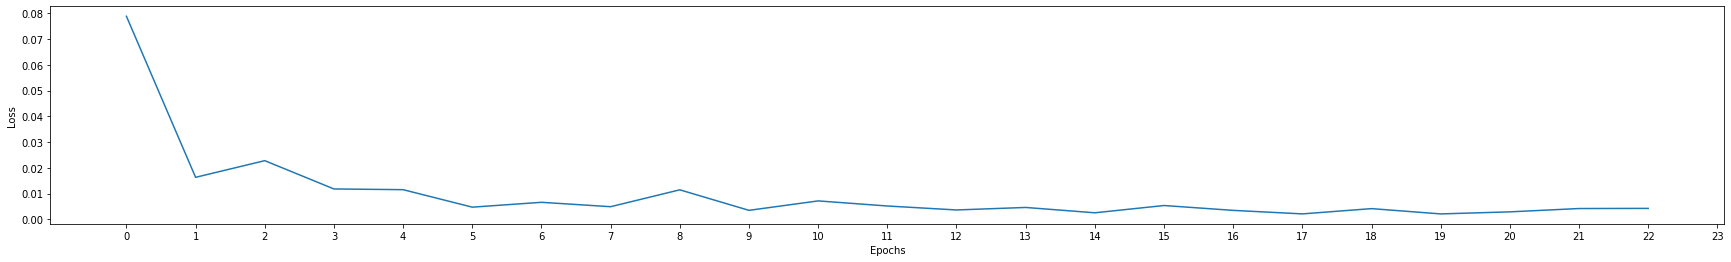

In [117]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize = (30, 4))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(np.arange(0, 100, 1))
plt.plot(range(len(losses_lstm)), losses_lstm)

In [0]:
lstm_predictions_scaled = []

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:, 1:, :],[[lstm_pred]],axis = 1)

In [119]:
prediction = pd.DataFrame(scaler.inverse_transform(lstm_predictions_scaled))
prediction.head()

,0
0,1675.474436
1,1684.602431
2,1687.289961
3,1679.911847
4,1657.913795


## Reference
- [Machine learning on Coronavirus](https://www.kaggle.com/vanshjatana/machine-learning-on-coronavirus)  
- [K-Means clustering](https://nbviewer.jupyter.org/github/nborwankar/LearnDataScience/blob/master/notebooks/D3.%20K-Means%20Clustering%20Analysis.ipynb)